# Data analysis and visualization of gas mileage in my rx8

## Background

I've collected information at each gas fill up for the past few years: the date, miles driven since last fill up, amount of gas pumped into the tank, and the price per gallon. Each time the tank was filled up completely, allowing the average miles per gallon to be computed over the past tank. The pumps probably don't fill the tank up to the exact same amount each time, but it should be roughly close enough.

Modern cars have trip computers that can record a lot more information and give an instantaneous mileage calculation. It would be interesting to have that much data and take different factors into account, such as air temperature, tire pressure, etc. The biggest source of variation in mileage for my driving pattern is likely the number of cold starts in a day, of which I did not collect data.

# Summary of process and tools used

1. Record gas data in spreadsheet, and export as csv file
2. Load csv file into local MySQL database
3. Run Python through Jupyter Notebook
4. Connect to MySQL database using Python
5. Perform data analysis and visualization in Python
6. Control versions and save to Github using Git
7. Done on Mac OS X with Bash shell

## Exploratory data analysis

First we load packages.

In [1]:
import MySQLdb as mdb
import sys
import pandas as pd
import pandas.io.sql
import numpy as np
from numpy import log
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from datetime import datetime

Next we connect to the MySQL database and load the entire table as a pandas dataframe.

In [2]:
con = mdb.connect(host='localhost', db='mpg_db', read_default_file='~/.my.cnf')
gas_data = pd.read_sql("SELECT * FROM mpg_table", con)
con.close()

In [3]:
print(type(gas_data)) #shows type as pandas dataframe
#print(gas_data) #shows the table
print(list(gas_data)) #shows some info about the fields in the table

<class 'pandas.core.frame.DataFrame'>
['thedate', 'days', 'odometer', 'miles', 'gallons', 'cost', 'costpergal', 'station', 'style', 'mpg', 'mpdol', 'dolpm', 'mpd', 'gpd', 'dolpd']


Here's an example of using the dataframe to get the mean of the mpg column.

In [4]:
print('%.2f' % np.mean(gas_data['mpg'])) #prints two decimal places

14.42


Now we plot the mileage over time.

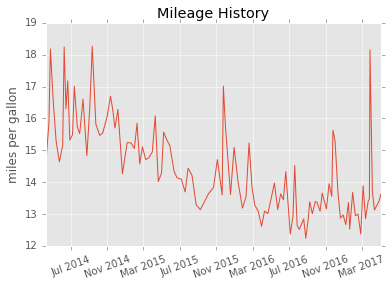

In [5]:
plt.plot_date(matplotlib.dates.date2num(gas_data['thedate']), 
              gas_data['mpg'], '-')
plt.title('Mileage History')
plt.ylabel('miles per gallon')
plt.xticks(rotation=20)
plt.show()

Here we make a boxplot of the overall mileage.

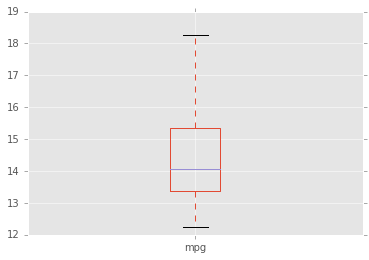

In [6]:
gas_data['mpg'].plot.box() #pandas wrapper of matplotlib?
#plt.boxplot(gas_data['mpg']) #alternative
plt.show()

Here's a plot of gas prices over time. Costco is significantly cheaper than other stations, so the graph is misleading in general. The second plot distinguishes between stations.

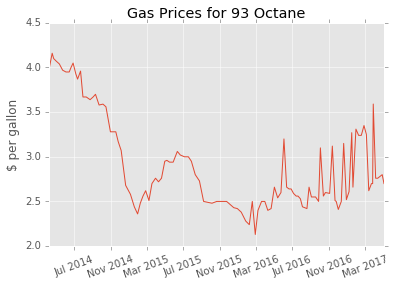

In [7]:
plt.plot_date(matplotlib.dates.date2num(gas_data['thedate']), 
                         gas_data['costpergal'], '-') #time-mpg
plt.title('Gas Prices for 93 Octane')
plt.ylabel('$ per gallon')
plt.xticks(rotation=20)
plt.show()

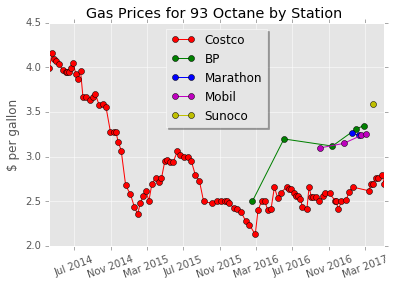

In [8]:
plt.plot_date(matplotlib.dates.date2num(gas_data[gas_data.station=='Costco'].thedate), 
              gas_data[gas_data.station=='Costco'].costpergal, 'r-o', label='Costco')
plt.plot_date(matplotlib.dates.date2num(gas_data[gas_data.station=='BP'].thedate), 
              gas_data[gas_data.station=='BP'].costpergal, 'g-o', label='BP')
plt.plot_date(matplotlib.dates.date2num(gas_data[gas_data.station=='Marathon'].thedate), 
              gas_data[gas_data.station=='Marathon'].costpergal, 'b-o', label='Marathon')
plt.plot_date(matplotlib.dates.date2num(gas_data[gas_data.station=='Mobil'].thedate), 
              gas_data[gas_data.station=='Mobil'].costpergal, 'm-o', label='Mobil')
plt.plot_date(matplotlib.dates.date2num(gas_data[gas_data.station=='Sunoco'].thedate), 
              gas_data[gas_data.station=='Sunoco'].costpergal, 'y-o', label='Sunoco')
#clean this up into a loop
              
#gas_data[gas_data.station=='BP'].plot(x='thedate', y='costpergal', color='blue') 
#pandas wrapper
plt.xticks(rotation=20)
plt.title('Gas Prices for 93 Octane by Station ')
plt.ylabel('$ per gallon')
plt.legend(loc='upper center', shadow='true') #move outside of graph to right
plt.show()

The following is a plot of mileage given the number of miles driven per day. The MpD is used as an indicator of highway driving, and we expect highway driving to produce better MpG.

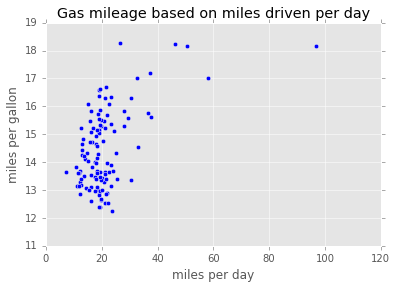

In [9]:
plt.scatter(gas_data['mpd'], gas_data['mpg'])
plt.ylabel('miles per gallon')
plt.xlabel('miles per day')
plt.title('Gas mileage based on miles driven per day')
plt.show()

Now let's make two boxplots grouped by what looks like city mileage and mixed highway mileage.

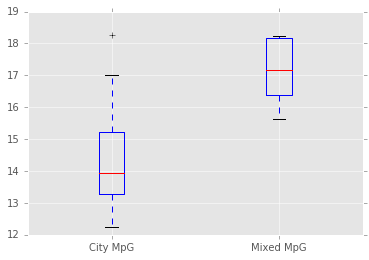

In [10]:
cutoff=35 #set cutoff between two groups
#fig = plt.figure()
#ax = fig.add_subplot(111)
plt.boxplot([gas_data[gas_data.mpd<cutoff].mpg,gas_data[gas_data.mpd>=cutoff].mpg])
plt.xticks([1, 2], ['City MpG', 'Mixed MpG'])
plt.show()
#gas_data[(gas_data.mpd>cutoff) & (gas_data.station=='Costco')].mpg
#above shows how t select multiple conditions

New tires were put on after the December 6th, 2014 fill up. These tires had a stickier compund which reduced the mileage.

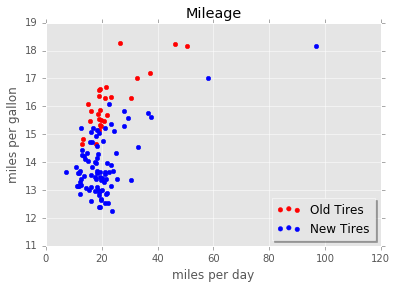

In [11]:
#gas_data[gas_data.thedate<datetime.strptime('2014-12-07','%Y-%m-%d').date()].mpd
#also consider num2date from matplotlib
tire_date=datetime.strptime('2014-12-07','%Y-%m-%d').date() #when tires were changed

plt.scatter(gas_data[gas_data.thedate<tire_date].mpd, 
            gas_data[gas_data.thedate<tire_date].mpg, 
            color='red', label='Old Tires')
plt.scatter(gas_data[gas_data.thedate>tire_date].mpd, 
            gas_data[gas_data.thedate>tire_date].mpg, 
            color='blue', label='New Tires')
plt.title('Mileage')
plt.ylabel('miles per gallon')
plt.xlabel('miles per day')
plt.legend(loc='lower right', shadow='true')
plt.show()

Let's look at box plots comparing the old and new tires now.

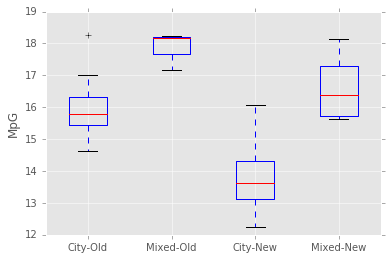

In [12]:
cutoff=35 #set cutoff between two groups

plt.boxplot([gas_data[(gas_data.mpd<cutoff)  & (gas_data.thedate<tire_date)].mpg, 
             gas_data[(gas_data.mpd>=cutoff) & (gas_data.thedate<tire_date)].mpg, 
             gas_data[(gas_data.mpd<cutoff)  & (gas_data.thedate>tire_date)].mpg,
             gas_data[(gas_data.mpd>=cutoff) & (gas_data.thedate>tire_date)].mpg
            ])
plt.xticks([1, 2, 3, 4], ['City-Old', 'Mixed-Old', 'City-New', 'Mixed-New'])
plt.ylabel('MpG')
plt.show()
##gas_data[(gas_data.mpd>cutoff) & (gas_data.station=='Costco')].mpg
##gas_data[(gas_data.mpd>cutoff) & (gas_data.thedate<datetime.strptime('2014-12-07','%Y-%m-%d').date())].mpg

## Regression analysis

Here we run a linear regression using the statsmodel library.

In [13]:
regression = smf.ols(formula = 'mpg ~ mpd', data = gas_data).fit()
print(regression.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     44.47
Date:                Sat, 20 May 2017   Prob (F-statistic):           1.02e-09
Time:                        22:15:57   Log-Likelihood:                -182.15
No. Observations:                 114   AIC:                             368.3
Df Residuals:                     112   BIC:                             373.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.9140      0.253     51.011      0.0

Here's an alternative method to get some regression data using the scikit library.

In [14]:
mpg_data2 = gas_data[['mpg']]
mpd_data2 = gas_data[['mpd']]
sk_regr = linear_model.LinearRegression()
sk_regr.fit(mpd_data2, mpg_data2)
print 'coefficient: {0:.4f}'.format(sk_regr.coef_[0][0])
print 'intercept: {0:.4f}'.format(sk_regr.intercept_[0])
print 'R-squared: {0:.3f}'.format(sk_regr.score(mpd_data2, mpg_data2))

coefficient: 0.0723
intercept: 12.9140
R-squared: 0.284


We can see the data matches up with both methods. This linear model isn't a great fit, as indicated by the R-squared value. Let's plot it over the scatter plot from earlier.

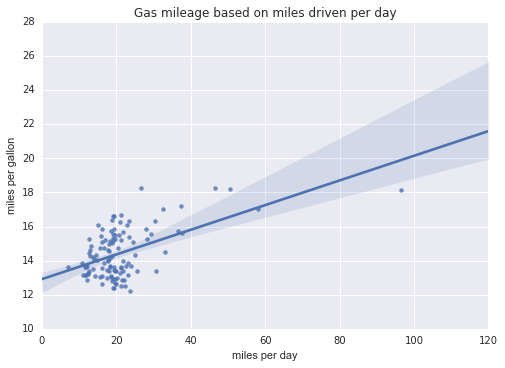

In [15]:
import seaborn as sns
sns.regplot(gas_data['mpd'], gas_data['mpg']) #with seaborn
#next two lines would plot the line directly
#x = np.arange(0, 100)
#plt.plot(sk_regr.coef_[0][0]*x+sk_regr.intercept_[0], 'r')
plt.ylabel('miles per gallon')
plt.xlabel('miles per day')
plt.title('Gas mileage based on miles driven per day')
plt.show()

Here's a locally weighted linear regression model.

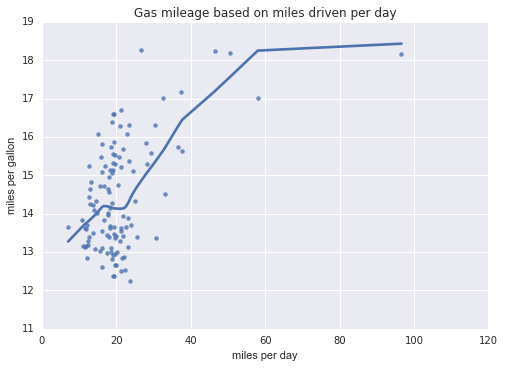

In [16]:
import seaborn as sns
sns.regplot(gas_data['mpd'], gas_data['mpg'], lowess=True)
plt.ylabel('miles per gallon')
plt.xlabel('miles per day')
plt.title('Gas mileage based on miles driven per day')
plt.show()

Let's plot two lines based on the old and new tires.

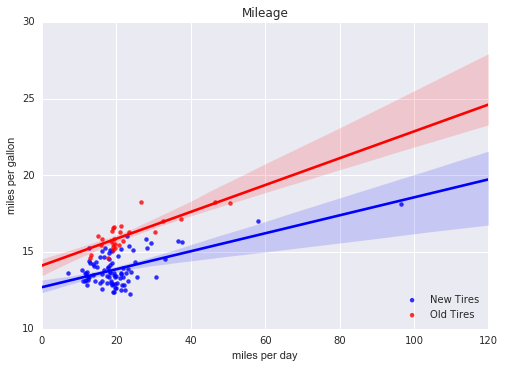

In [17]:
sns.regplot(gas_data[gas_data.thedate>tire_date].mpd, 
            gas_data[gas_data.thedate>tire_date].mpg,
            color='blue', label='New Tires')
sns.regplot(gas_data[gas_data.thedate<tire_date].mpd, 
            gas_data[gas_data.thedate<tire_date].mpg,
            color='red', label='Old Tires')
plt.ylabel('miles per gallon')
plt.xlabel('miles per day')
plt.title('Mileage')
plt.legend(loc='lower right')
plt.show()

Here's some linear regression information for the old and new tires done separately. It looks like we have a better result for the old tires.

In [18]:
print'Old Tires'
mpg_data_O = gas_data[gas_data.thedate<tire_date][['mpg']]
mpd_data_O = gas_data[gas_data.thedate<tire_date][['mpd']]
sk_regr_O = linear_model.LinearRegression()
sk_regr_O.fit(mpd_data_O, mpg_data_O)
print 'coefficient: {0:.4f}'.format(sk_regr_O.coef_[0][0])
print 'intercept: {0:.4f}'.format(sk_regr_O.intercept_[0])
print 'R-squared: {0:.3f}'.format(sk_regr_O.score(mpd_data_O, mpg_data_O))

print '\n' + 'New Tires'
mpg_data_N = gas_data[gas_data.thedate>tire_date][['mpg']]
mpd_data_N = gas_data[gas_data.thedate>tire_date][['mpd']]
sk_regr_N = linear_model.LinearRegression()
sk_regr_N.fit(mpd_data_N, mpg_data_N)
print 'coefficient: {0:.4f}'.format(sk_regr_N.coef_[0][0])
print 'intercept: {0:.4f}'.format(sk_regr_N.intercept_[0])
print 'R-squared: {0:.3f}'.format(sk_regr_N.score(mpd_data_N, mpg_data_N))

Old Tires
coefficient: 0.0874
intercept: 14.1235
R-squared: 0.638

New Tires
coefficient: 0.0585
intercept: 12.7123
R-squared: 0.343


We can also try a log model, however the fit appears to be even worse.

In [19]:
gas_data['log_mpd'] = log(gas_data['mpd'])
gas_data['log_mpg'] = log(gas_data['mpg'])
log_lm = smf.ols(formula = 'log_mpg ~ log_mpd', data = gas_data).fit()
print(log_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                log_mpg   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     36.40
Date:                Sat, 20 May 2017   Prob (F-statistic):           2.12e-08
Time:                        22:15:58   Log-Likelihood:                 122.19
No. Observations:                 114   AIC:                            -240.4
Df Residuals:                     112   BIC:                            -234.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2722      0.065     34.708      0.0